The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.14.3


#  Sequence to Sequence
:label:`sec_seq2seq`

The sequence to sequence (seq2seq) model is based on the encoder-decoder architecture to generate a sequence output for a sequence input, as demonstrated in :numref:`fig_seq2seq`. Both the encoder and the decoder use recurrent neural networks (RNNs) to handle sequence inputs of variable length. The hidden state of the encoder is used directly to initialize the decoder hidden state to pass information from the encoder to the decoder.

![The sequence to sequence model architecture.](http://d2l.ai/_images/seq2seq.svg)
:label:`fig_seq2seq`

The layers in the encoder and the decoder are illustrated in :numref:`fig_seq2seq_details`.

![Layers in the encoder and the decoder.](../img/seq2seq-details.svg)
:label:`fig_seq2seq_details`

In this section we will explain and implement the seq2seq model to train on the machine translation dataset.


In [1]:
from d2l import torch as d2l
import torch
from torch import nn

## Encoder

Recall that the encoder of seq2seq can transform the inputs of variable length to a fixed-length context vector $\mathbf{c}$ by encoding the sequence information into $\mathbf{c}$. We usually use RNN layers within the encoder.
Suppose that we have an input sequence $x_1, \ldots, x_T$, where $x_t$ is the $t^\mathrm{th}$ word. At timestep $t$, the RNN will have two vectors as the input: the feature vector $\mathbf{x}_t$ of $x_t$ and the hidden state of the last timestep $\mathbf{h}_{t-1}$. Let us denote the transformation of the RNN's hidden states by a function $f$:

$$\mathbf{h}_t = f (\mathbf{x}_t, \mathbf{h}_{t-1}).$$

Next, the encoder captures information of all the hidden states and encodes it into the context vector $\mathbf{c}$ with a function $q$:

$$\mathbf{c} = q (\mathbf{h}_1, \ldots, \mathbf{h}_T).$$

For example, if we choose $q$ as $q (\mathbf{h}_1, \ldots, \mathbf{h}_T) = \mathbf{h}_T$, then the context vector will be the final hidden state $\mathbf{h}_T$.

So far what we describe above is a unidirectional RNN, where each timestep's hidden state depends only on the previous timesteps'. We can also use other forms of RNNs such as GRUs, LSTMs, and bidirectional RNNs to encode the sequential input.

Now let us implement the seq2seq's encoder.
Here we use the word embedding layer to obtain the feature vector
according to the word index of the input language.
Those feature vectors will be fed to a multi-layer LSTM.
The input for the encoder is a batch of sequences, which is 2-D tensor with shape (batch size, sequence length). The encoder returns both the LSTM outputs, i.e., hidden states of all the timesteps, as well as the hidden state and the memory cell of the final timestep.


In [2]:
#@save
class Seq2SeqEncoder(d2l.Encoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, num_hiddens, num_layers, dropout=dropout)

    def forward(self, X, *args):
        X = self.embedding(X)  # X shape: (batch_size, seq_len, embed_size)
        # RNN needs first axes to be timestep, i.e., seq_len
        X = X.permute(1, 0, 2)
        out, state = self.rnn(X) # When state is not mentioned, it defaults to zeros
        # out shape: (seq_len, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens),
        # where "state" contains the hidden state and the memory cell
        return out, state

Next, we will create a minibatch sequence input with a batch size of 4 and 7 timesteps. We assume the number of hidden layers of the LSTM unit is 2 and the number of hidden units is 16. The output shape returned by the encoder after performing forward calculation on the input is (number of timesteps, batch size, number of hidden units). The shape of the multi-layer hidden state of the gated recurrent unit in the final timestep is (number of hidden layers, batch size, number of hidden units). For the gated recurrent unit, the `state` list contains only one element, which is the hidden state. If long short-term memory is used, the `state` list will also contain another element, which is the memory cell.


In [3]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape

torch.Size([7, 4, 16])

Since an LSTM is used, the `state` list will contain both the hidden state and the memory cell with same shape (number of hidden layers, batch size, number of hidden units). However, if a GRU is used, the `state` list will contain only one element---the hidden state in the final timestep with shape (number of hidden layers, batch size, number of hidden units).


In [4]:
len(state), state[0].shape, state[1].shape

(2, torch.Size([2, 4, 16]), torch.Size([2, 4, 16]))

## Decoder
:label:`sec_seq2seq_decoder`

As we just introduced, the context vector $\mathbf{c}$ encodes the information from the whole input sequence $x_1, \ldots, x_T$. Suppose that the given outputs in the training set are $y_1, \ldots, y_{T'}$. At each timestep $t'$, the conditional probability of output $y_{t'}$ will depend on the previous output sequence $y_1, \ldots, y_{t'-1}$ and the context vector $\mathbf{c}$, i.e.,

$$P(y_{t'} \mid y_1, \ldots, y_{t'-1}, \mathbf{c}).$$

Hence, we can use another RNN as the decoder. At timestep $t'$, the decoder will update its hidden state $\mathbf{s}_{t'}$ using three inputs: the feature vector $\mathbf{y}_{t'-1}$ of $y_{t'-1}$, the context vector $\mathbf{c}$, and the hidden state of the last timestep $\mathbf{s}_{t'-1}$. Let us denote the transformation of the RNN's hidden states within the decoder by a function $g$:

$$\mathbf{s}_{t'} = g(\mathbf{y}_{t'-1}, \mathbf{c}, \mathbf{s}_{t'-1}).$$


When implementing the decoder, we directly use the hidden state of the encoder in the final timestep as the initial hidden state of the decoder. This requires that the encoder and decoder RNNs have the same numbers of layers and hidden units.
The LSTM forward calculation of the decoder is similar to that of the encoder. The only difference is that we add a dense layer after the LSTM layers, where the hidden size is the vocabulary size. The dense layer will predict the confidence score for each word.


In [5]:
#@save
class Seq2SeqDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        X = self.embedding(X).permute(1, 0, 2)
        out, state = self.rnn(X, state)
        # Make the batch to be the first dimension to simplify loss computation
        out = self.dense(out).permute(1, 0, 2)
        return out, state

We create a decoder with the same hyperparameters as the encoder. As we can see, the output shape is changed to (batch size, the sequence length, vocabulary size).


In [6]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8,
                         num_hiddens=16, num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
out, state = decoder(X, state)
out.shape, len(state), state[0].shape, state[1].shape

(torch.Size([4, 7, 10]), 2, torch.Size([2, 4, 16]), torch.Size([2, 4, 16]))

## The Loss Function

For each timestep, the decoder outputs a vocabulary-size confidence score vector to predict words. Similar to language modeling, we can apply softmax to obtain the probabilities and then use cross-entropy loss to calculate the loss. Note that we padded the target sentences to make them have the same length, but we do not need to compute the loss on the padding symbols.

To implement the loss function that filters out some entries, we will use an operator called `SequenceMask`. It can specify to mask the first dimension (`axis=0`) or the second one (`axis=1`). If the second one is chosen, given a valid length vector `len` and 2-dim input `X`, this operator sets `X[i, len[i]:] = 0` for all $i$'s.


In [7]:
#@save
def sequence_mask(X, valid_len, value=0):
    output = X.clone()
    for count, matrix in enumerate(output):
        matrix[int(valid_len[count]):]=value
    return output

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

Apply to $n$-dim tensor $X$, it sets `X[i, len[i]:, :, ..., :] = 0`. In addition, we can specify the filling value such as $-1$ as shown below.


In [8]:
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]), value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

Now we can implement the masked version of the softmax cross-entropy loss. Note that each Gluon loss function allows to specify per-example weights, in default they are 1s. Then we can just use a zero weight for each example we would like to remove. So our customized loss function accepts an additional `valid_len` argument to ignore some failing elements in each sequence.


In [9]:
#@save
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    # pred shape: (batch_size, seq_len, vocab_size)
    # label shape: (batch_size, seq_len)
    # valid_len shape: (batch_size, )
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(pred.permute(0,2,1), label)
        weighted_loss = (unweighted_loss*weights).mean(dim=1)
        return weighted_loss

For a sanity check, we create identical three sequences, keep 4 elements for the first sequence, 2 elements for the second sequence, and none for the last one. Then the first example loss should be 2 times larger than the second one, and the last loss should be 0.


In [10]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long), torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

## Training
:label:`sec_seq2seq_training`

During training, if the target sequence has length $n$, we feed the first $n-1$ tokens into the decoder as inputs, and the last $n-1$ tokens are used as ground truth label.


In [11]:
#@save
def train_s2s_ch9(model, data_iter, lr, num_epochs, device):
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.LSTM:
            for param in m._flat_weights_names:
                if "weight" in param:
                    torch.nn.init.xavier_uniform_(m._parameters[param])
    model.apply(xavier_init_weights)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    model.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], ylim=[0, 0.25])
    for epoch in range(1, num_epochs + 1):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # loss_sum, num_tokens
        for batch in data_iter:
            X, X_vlen, Y, Y_vlen = [x.to(device) for x in batch]
            Y_input, Y_label, Y_vlen = Y[:, :-1], Y[:, 1:], Y_vlen-1
            Y_hat, _ = model(X, Y_input, X_vlen, Y_vlen)
            l = loss(Y_hat, Y_label, Y_vlen)
            l.sum().backward() # Making the loss scalar for backward()
            d2l.grad_clipping(model, 1)
            num_tokens = Y_vlen.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if epoch % 10 == 0:
            animator.add(epoch, (metric[0]/metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

Next, we create a model instance and set hyperparameters. Then, we can train the model.


loss 0.023, 11659.8 tokens/sec on cuda:0


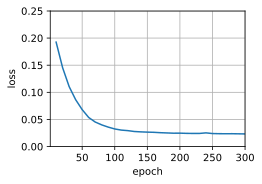

In [12]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.0
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

src_vocab, tgt_vocab, train_iter = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.EncoderDecoder(encoder, decoder)
train_s2s_ch9(model, train_iter, lr, num_epochs, device)

## Predicting

Here we implement the simplest method, greedy search, to generate an output
sequence. As illustrated in :numref:`fig_seq2seq_predict`, during predicting, we feed the same "&lt;bos&gt;" token to the decoder as training at timestep 0. But the input token for a later timestep is the predicted token from the previous timestep.

![Sequence to sequence model predicting with greedy search](http://d2l.ai/_images/seq2seq_predict.svg)
:label:`fig_seq2seq_predict`


In [13]:
#@save
def predict_s2s_ch9(model, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device):
    src_tokens = src_vocab[src_sentence.lower().split(' ')]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    enc_X = torch.tensor(src_tokens, dtype=torch.long, device=device)
    # Add the  batch size dimension
    enc_outputs = model.encoder(torch.unsqueeze(enc_X, dim=0),
                                enc_valid_len)
    dec_state = model.decoder.init_state(enc_outputs, enc_valid_len)
    dec_X = torch.unsqueeze(torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    predict_tokens = []
    for _ in range(num_steps):
        Y, dec_state = model.decoder(dec_X, dec_state)
        # The token with highest score is used as the next timestep input
        dec_X = Y.argmax(dim=2)
        py = dec_X.squeeze(dim=0).type(torch.int32).item()
        if py == tgt_vocab['<eos>']:
            break
        predict_tokens.append(py)
    return ' '.join(tgt_vocab.to_tokens(predict_tokens))

Try several examples:


In [14]:
for sentence in ['Go .', 'Wow !', "I'm OK .", 'I won !']:
    print(sentence + ' => ' + predict_s2s_ch9(
        model, sentence, src_vocab, tgt_vocab, num_steps, device))

Go . => va !
Wow ! => <unk> !
I'm OK . => je vais bien .
I won ! => j'ai gagné !


## Summary

* The sequence to sequence (seq2seq) model is based on the encoder-decoder architecture to generate a sequence output from a sequence input.
* We use multiple LSTM layers for both the encoder and the decoder.


## Exercises

1. Can you think of other use cases of seq2seq besides neural machine translation?
1. What if the input sequence in the example of this section is longer?
1. If we do not use the `SequenceMask` in the loss function, what may happen?
